# Ungraded Lab: Building Models for the IMDB Reviews Dataset

In this lab, you will build four models and train it on the [IMDB Reviews dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) with full word encoding. These use different layers after the embedding namely `Flatten`, `LSTM`, `GRU`, and `Conv1D`. You will compare the performance and see which architecture might be best for this particular dataset. Let's begin!

## Imports

You will first import common libraries that will be used throughout the exercise.

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Download and Prepare the Dataset

Next, you will download the `plain_text` version of the `IMDB Reviews` dataset.

In [2]:
# The dataset is already downloaded for you. For downloading you can use the code below.
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="../data/", download=False)

In [3]:
# Get the train and test sets
train_dataset, test_dataset = imdb['train'], imdb['test']

Then, you will build the vocabulary based on the training set.

In [4]:
# Vectorization and Padding Parameters

VOCAB_SIZE = 10000
MAX_LENGTH = 120
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [5]:
# Instantiate the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

# Get the string inputs and integer outputs of the training set
train_reviews = train_dataset.map(lambda review, label: review)

# Generate the vocabulary based only on the training set
vectorize_layer.adapt(train_reviews)

# Delete because it's no longer needed
del train_reviews

In Week 2, you generated the padded sequences by chaining `map()` and `apply()` methods. Here's a similar way to do that. You will just call an `apply()` then do the transformations in one preprocessing function.

In [6]:
def preprocessing_fn(dataset):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Apply the vectorization layer to the string features
  dataset_sequences = dataset.map(
      lambda text, label: (vectorize_layer(text), label)
      )

  # Put all elements in a single ragged batch
  dataset_sequences = dataset_sequences.ragged_batch(
      batch_size=dataset_sequences.cardinality()
      )

  # Output a tensor from the single batch. Extract the sequences and labels.
  sequences, labels = dataset_sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(
      sequences.numpy(),
      maxlen=MAX_LENGTH,
      truncating=TRUNC_TYPE,
      padding=PADDING_TYPE
      )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
  labels = tf.data.Dataset.from_tensor_slices(labels)

  # Combine the padded sequences and labels
  dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)

  return dataset_vectorized

In [7]:
# Preprocess the train and test data
train_dataset_vectorized = train_dataset.apply(preprocessing_fn)
test_dataset_vectorized = test_dataset.apply(preprocessing_fn)

View a couple of examples. You should see tuples of tensors with a padded sequence and label.

In [8]:
# View 2 training sequences and its labels
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,   11,   14,   34,  412,  384,   18,   90,
         28,    1,    8,   33, 1322, 3560,   42,  487,    1,  191,   24,
         85,  152,   19,   11,  217,  316,   28,   65,  240,  214,    8,
        489,   54,   65,   85,  112,   96,   22, 5596,   11,   93,  642,
        743,   11,   18,    7,   34,  394, 9522,  170, 2464,  408,    2,
         88, 1216,  137,   66,  144,   51,    2,    1, 7558,   66,  245,
         65, 2870,   16,    1, 2860,    1,    1, 1426, 5050,    3,   40,
          1, 1579,   17, 3560,   14,  158,   19,    4, 1216,  891, 8040,
          8,    4,   18,   12,   14, 4059,    5,   99,  146, 1241,   10,
        237,  704,   12,   48,   24,   93,   39,   11, 7339,  152,   39,
       1322,    1,   50,  398,   10,   96, 1155,  851,  141,    9],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0

You will do the optimization and batching as usual.

In [9]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize and batch the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

## Plot Utility

The function below will visualize the accuracy and loss history after training.

In [10]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

## Model 1: Flatten

First up is simply using a `Flatten` layer after the embedding. Its main advantage is that it is very fast to train. Observe the results below.

In [11]:
# Parameters
EMBEDDING_DIM = 16
DENSE_DIM = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        11,526 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,533 (670.05 KB)

 Trainable params: 171,533 (670.05 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
NUM_EPOCHS = 10

# Train the model
history_flatten = model_flatten.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=(test_dataset_final))

Epoch 1/10


I0000 00:00:1734245740.563244     211 service.cc:145] XLA service 0x79c3484da980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734245740.563738     211 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6


167/782 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.5190 - loss: 0.6928

I0000 00:00:1734245743.577957     211 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6188 - loss: 0.6226 - val_accuracy: 0.8136 - val_loss: 0.4053
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8738 - loss: 0.3067 - val_accuracy: 0.8176 - val_loss: 0.4189
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9510 - loss: 0.1470 - val_accuracy: 0.8107 - val_loss: 0.5040
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9920 - loss: 0.0422 - val_accuracy: 0.8076 - val_loss: 0.6000
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9981 - loss: 0.0138 - val_accuracy: 0.8046 - val_loss: 0.6795
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9993 - loss: 0.0064 - val_accuracy: 0.8059 - val_loss: 0.7420
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9997 - loss: 0.0026 - val_accuracy: 0.8043 - val_loss: 0.8063
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.8045 - val_

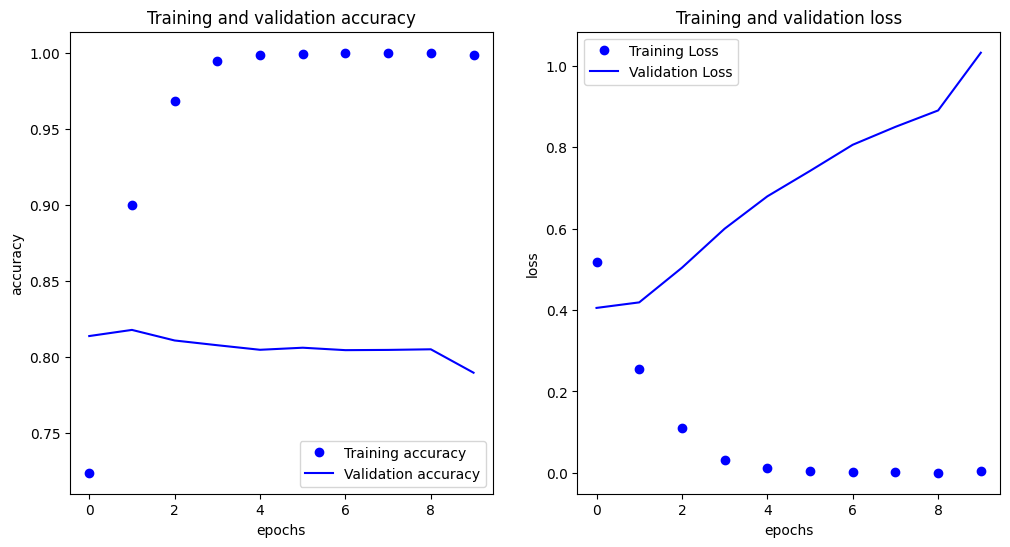

In [13]:
# Plot the accuracy and loss history
plot_loss_acc(history_flatten)

## LSTM

Next, you will use an LSTM. This is slower to train but useful in applications where the order of the tokens is important.

In [14]:
# Parameters
EMBEDDING_DIM = 16
LSTM_DIM = 32
DENSE_DIM = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,941 (675.55 KB)

 Trainable params: 172,941 (675.55 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
NUM_EPOCHS = 10

# Train the model
history_lstm = model_lstm.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.6396 - loss: 0.5978 - val_accuracy: 0.8116 - val_loss: 0.4069
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8671 - loss: 0.3225 - val_accuracy: 0.8184 - val_loss: 0.4122
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9023 - loss: 0.2550 - val_accuracy: 0.8152 - val_loss: 0.4744
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9211 - loss: 0.2063 - val_accuracy: 0.7958 - val_loss: 0.7258
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9327 - loss: 0.1782 - val_accuracy: 0.8051 - val_loss: 0.5633
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9501 - loss: 0.1377 - val_accuracy: 0.8006 - val_loss: 0.6534
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9657 - loss: 0.1005 - val_accuracy: 0.7989 - val_loss: 0.7312
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9767 - loss: 0.0686 - 

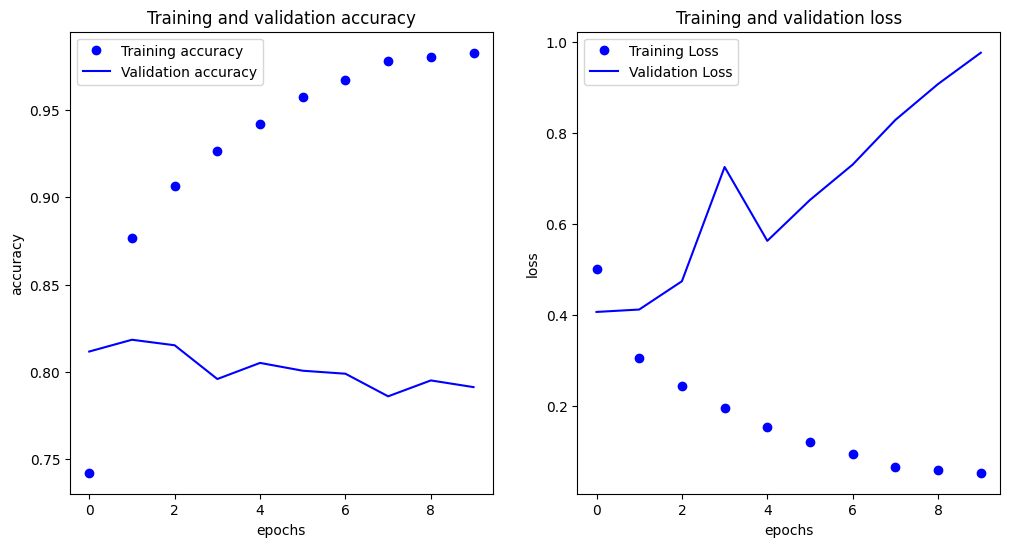

In [16]:
# Plot the accuracy and loss history
plot_loss_acc(history_lstm)

## GRU

The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. You will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.

In [17]:
# Parameters
EMBEDDING_DIM = 16
GRU_DIM = 32
DENSE_DIM = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(GRU_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,997 (664.05 KB)

 Trainable params: 169,997 (664.05 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
NUM_EPOCHS = 10

# Train the model
history_gru = model_gru.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=(test_dataset_final))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6036 - loss: 0.6191 - val_accuracy: 0.8233 - val_loss: 0.4025
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8592 - loss: 0.3367 - val_accuracy: 0.8120 - val_loss: 0.4217
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8999 - loss: 0.2570 - val_accuracy: 0.8044 - val_loss: 0.4718
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9282 - loss: 0.1946 - val_accuracy: 0.8126 - val_loss: 0.6090
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9493 - loss: 0.1431 - val_accuracy: 0.8009 - val_loss: 0.7191
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9638 - loss: 0.1033 - val_accuracy: 0.7980 - val_loss: 0.8095
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9752 - loss: 0.0689 - val_accuracy: 0.7914 - val_loss: 0.8981
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9845 - loss: 0.0467 - 

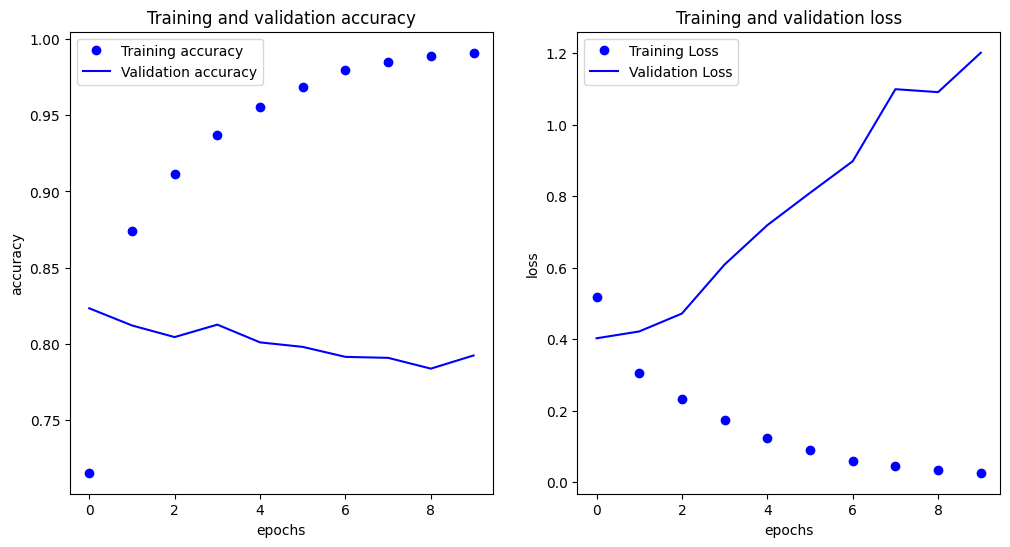

In [19]:
# Plot the accuracy and loss history
plot_loss_acc(history_gru)

## Convolution

Lastly, you will use a convolution layer to extract features from your dataset. You will append a [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer to reduce the results before passing it on to the dense layers. Like the model with `Flatten`, this also trains much faster than the ones using RNN layers like `LSTM` and `GRU`.

In [20]:
# Parameters
EMBEDDING_DIM = 16
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Conv1D(FILTERS, KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 116, 128)       │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,149 (668.55 KB)

 Trainable params: 171,149 (668.55 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
NUM_EPOCHS = 10

# Train the model
history_conv = model_conv.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=(test_dataset_final))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6721 - loss: 0.6148 - val_accuracy: 0.8136 - val_loss: 0.4747
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8649 - loss: 0.3921 - val_accuracy: 0.8194 - val_loss: 0.4031
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8996 - loss: 0.2609 - val_accuracy: 0.8246 - val_loss: 0.4237
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9212 - loss: 0.2156 - val_accuracy: 0.8197 - val_loss: 0.4691
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9395 - loss: 0.1762 - val_accuracy: 0.8076 - val_loss: 0.5943
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9550 - loss: 0.1419 - val_accuracy: 0.8077 - val_loss: 0.6313
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9674 - loss: 0.1104 - val_accuracy: 0.8038 - val_loss: 0.7368
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9745 - loss: 0.0912 - val_accuracy: 0.

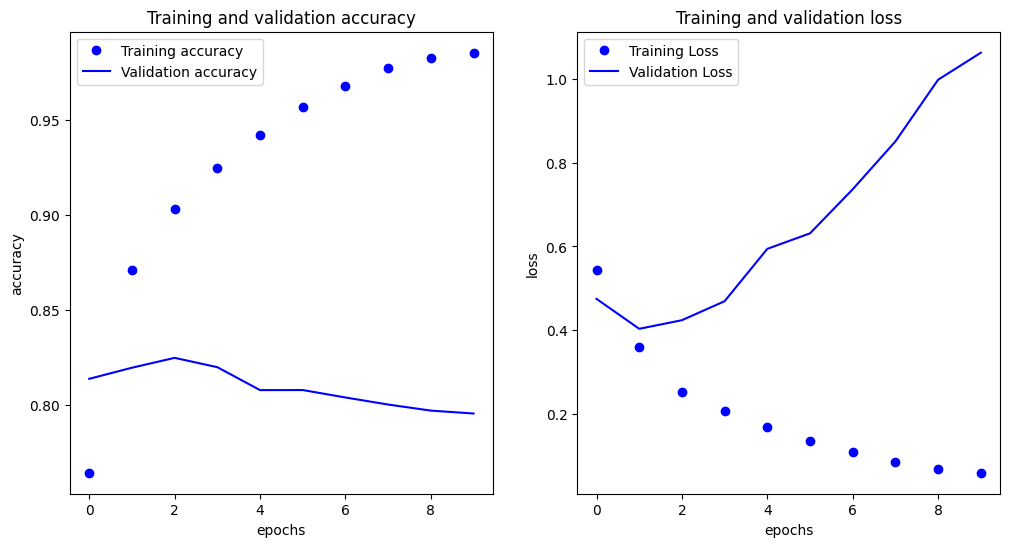

In [22]:
# Plot the accuracy and loss history
plot_loss_acc(history_conv)

## Wrap Up

Now that you've seen the results for each model, can you make a recommendation on what works best for this dataset? Do you still get the same results if you tweak some hyperparameters like the vocabulary size? Try tweaking some of the values some more so you can get more insight on what model performs best.

Run the cell below to free up resources for the next lab

In [23]:
# Shutdown the kernel to free up resources. 
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}